## Introduction

A time series is a succession of chronologically ordered data spaced at equal or unequal intervals. The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

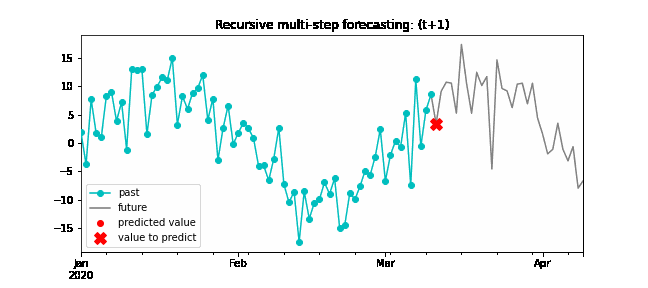

This tutorial describes how to use Scikit-learn regression models to perform forecasting on time series. Specifically, it introduces Skforecast, a simple library that contains the classes and functions necessary to adapt any Scikit-learn regression model to forecasting problems.

## Machine learning for forecasting

In order to apply machine learning models to forecasting problems, the time series has to be transformed into a matrix in which each value is related to the time window (lags) that precedes it.

In a time series context, a lag with respect to a time step  t  is defined as the values of the series at previous time steps. For example, lag 1 is the value at time step  t−1  and lag  m  is the value at time step  t−m .

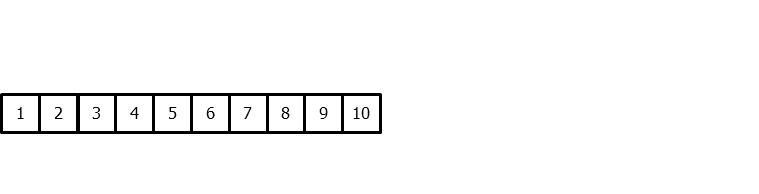

This type of transformation also allows to include additional variables.

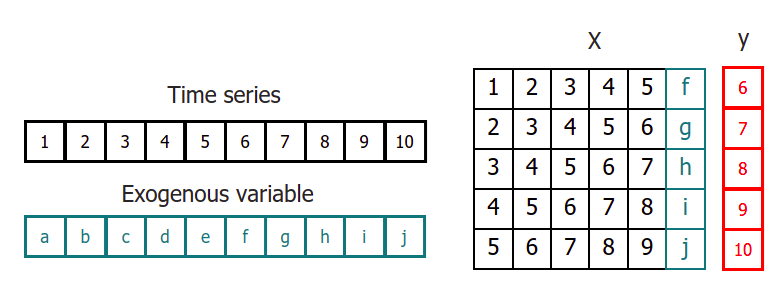

Once data have been rearranged into the new shape, any regression model can be trained to predict the next value (step) of the series. During model training, every row is considered a separate data instance, where values at lags 1, 2, ...  p  are considered predictors for the target quantity of the time series at time step  p+1 .

## Multi-Step Time Series Forecasting

When working with time series, it is seldom needed to predict only the next element in the series ( t+1 ). Instead, the most common goal is to predict a whole future interval (( t+1 ), ..., ( t+n )) or a far point in time ( t+n ). Several strategies allow generating this type of prediction.

### Recursive multi-step forecasting

Since the value  tn−1  is required to predict  tn , and  tn−1  is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting and can be easily generated with the ForecasterAutoreg and ForecasterAutoregCustom classes.

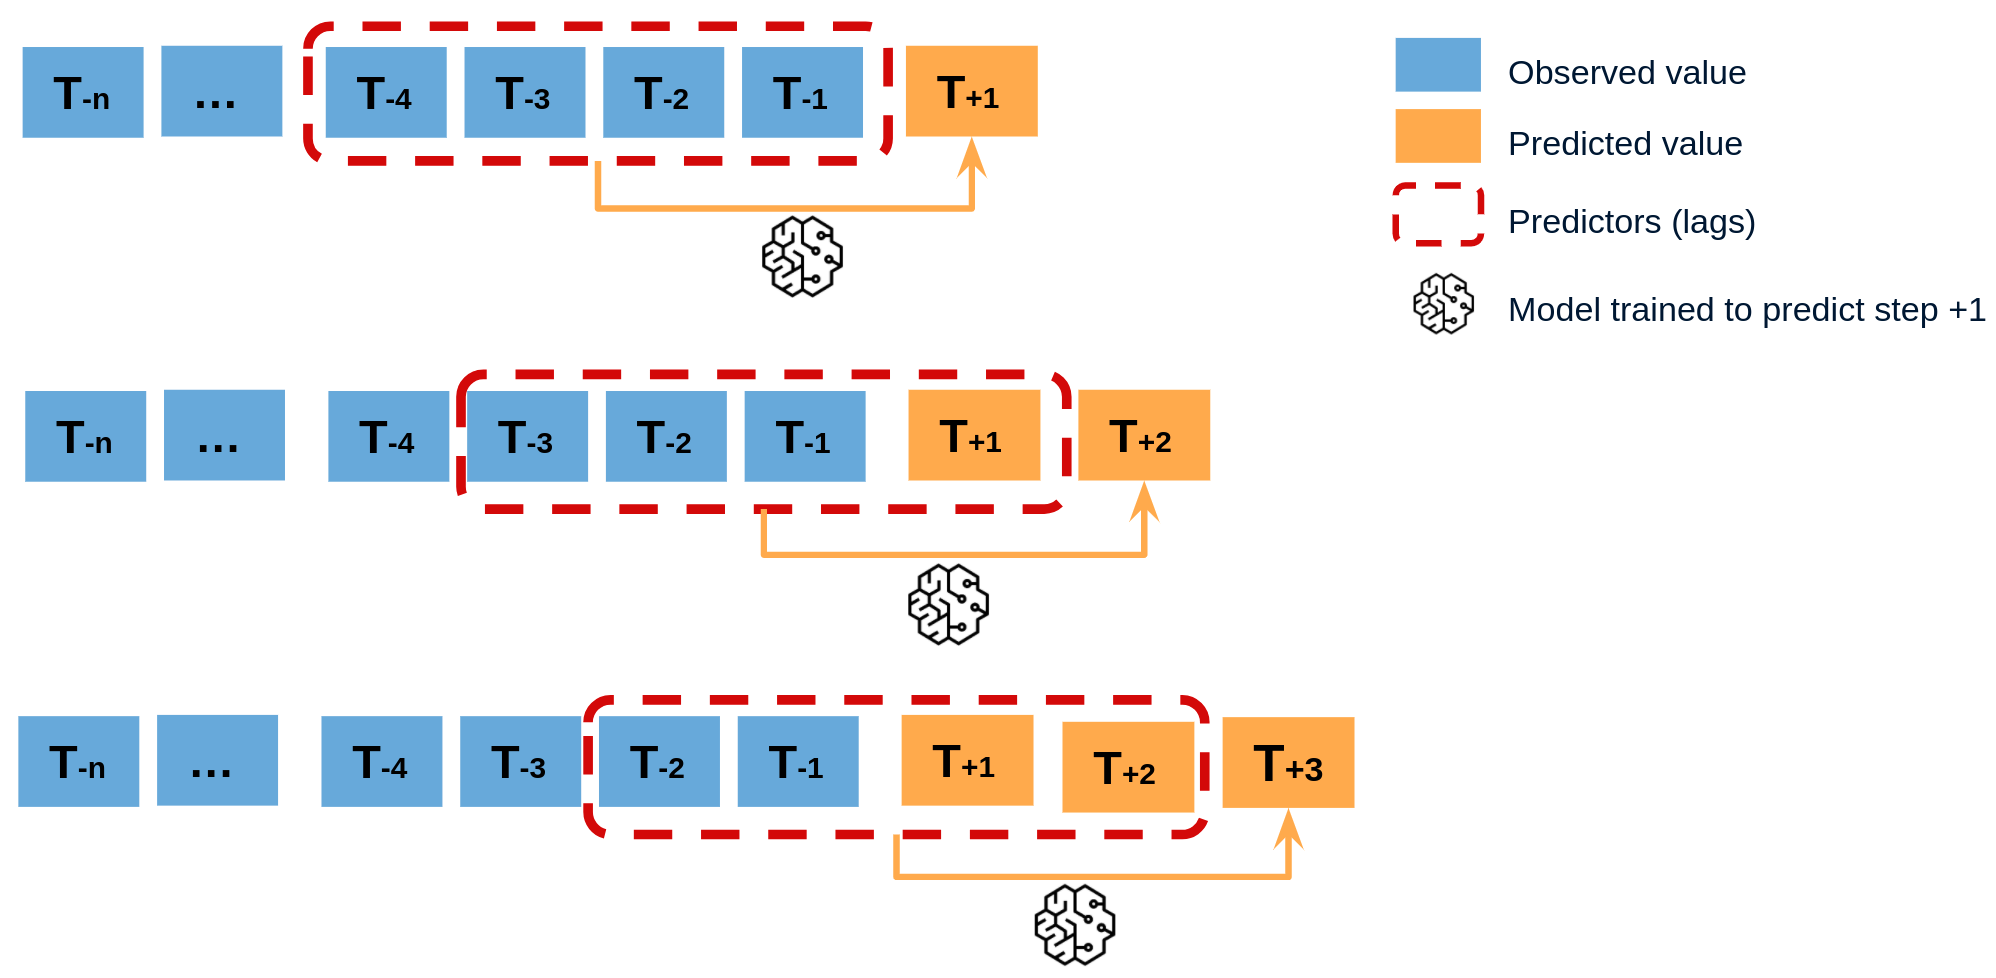

### Direct multi-step forecasting

Direct multi-step forecasting consists of training a different model for each step of the forecast horizon. For example, to predict the next 5 values of a time series, 5 different models are trained, one for each step. As a result, the predictions are independent of each other.

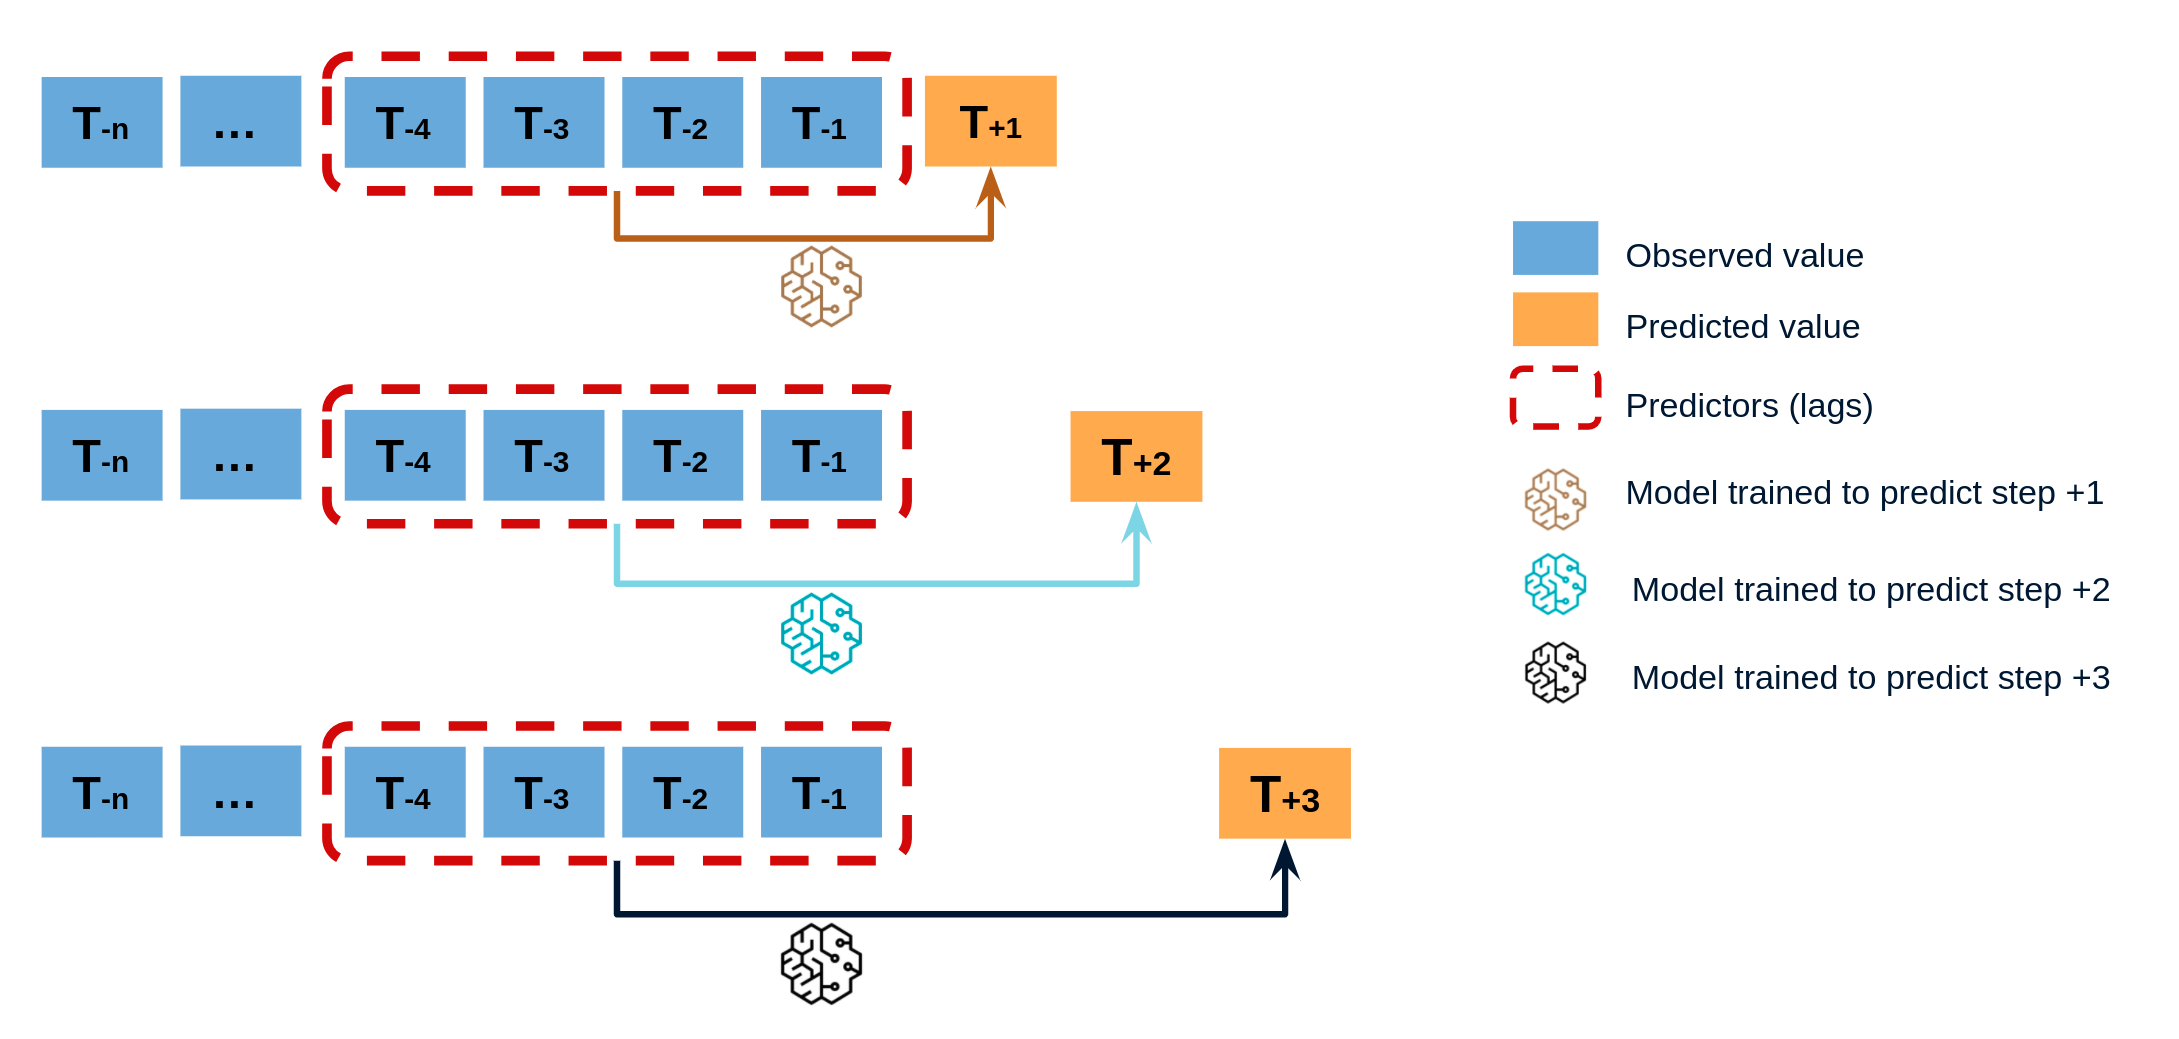

The main complexity of this approach is to generate the correct training matrices for each model. The ForecasterAutoregMultiOutput class of the skforecast library automates this process. It is also important to bear in mind that this strategy has a higher computational cost since it requires the train of multiple models. The following diagram shows the process for a case in which the response variable and two exogenous variables are available.

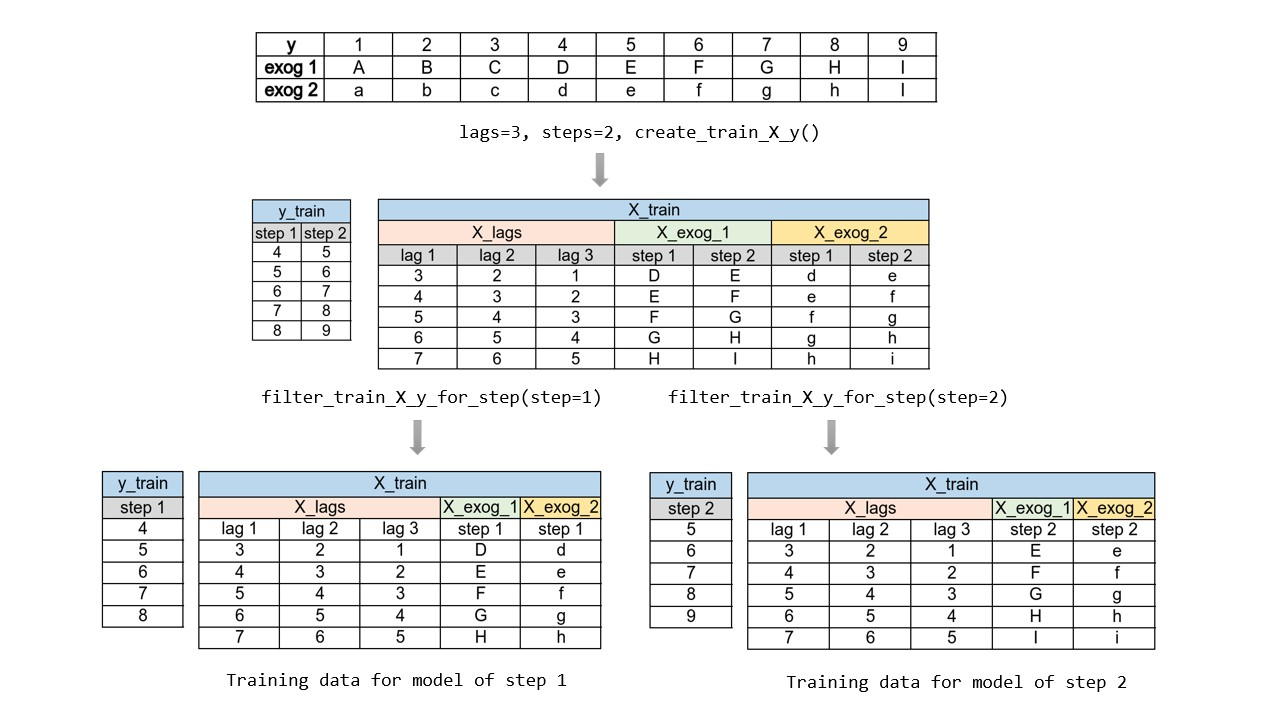

## Recursive autoregressive forecasting

A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. It is intended to create an autoregressive model capable of predicting future monthly expenditures.

### Libraries

In [1]:
#pip install skforecast --user

In [2]:
#pip install shap

In [3]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.plot import plot_prediction_intervals
import shap

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.15.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.3
Version numpy: 1.26.4


The data used in the examples of this tutorial have been obtained from the book Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos. (Its also available on Moodle)

In [4]:
data = pd.read_csv('h2o_exog.csv')

In [5]:
data.head()
#pip install hdbscan --no-cache-dir --no-binary :all: --no-build-isolation

fecha         y    exog_1    exog_2
0  1992-04-01  0.379808  0.958792  1.166029
1  1992-05-01  0.361801  0.951993  1.117859
2  1992-06-01  0.410534  0.952955  1.067942
3  1992-07-01  0.483389  0.958078  1.097376
4  1992-08-01  0.475463  0.956370  1.122199

In [6]:
data = data.rename(columns={'fecha': 'date'})
data.date = data.date.str.replace('-', '/')

The column date has been stored as a string. To convert it to datetime the pd.to_datetime() function can be use. Once in datetime format, and to make use of Pandas functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [7]:
# Data preparation
# ==============================================================================
#data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
#data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

y    exog_1    exog_2
date                                    
1992-04-01  0.379808  0.958792  1.166029
1992-05-01  0.361801  0.951993  1.117859
1992-06-01  0.410534  0.952955  1.067942
1992-07-01  0.483389  0.958078  1.097376
1992-08-01  0.475463  0.956370  1.122199

When setting a frequency with the asfreq() method, Pandas fills the gaps that may exist in the time series with the value of Null to ensure the indicated frequency, example. Therefore, it should be checked if missing values have appeared after this transformation.

In [8]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


Although it is unnecessary, since a frequency has been established, it is possible to verify that the time series is complete.

In [9]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


In [10]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

The last 36 months are used as the test set to evaluate the predictive capacity of the model.

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


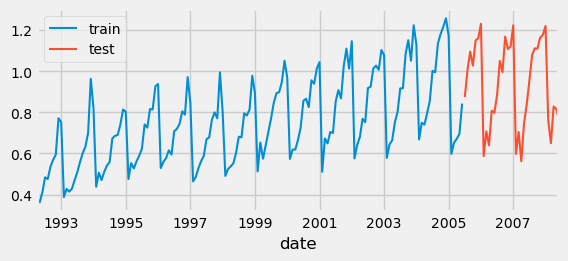

In [11]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [12]:
data_train['y'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 159 entries, 1992-04-01 to 2005-06-01
Freq: MS
Series name: y
Non-Null Count  Dtype  
--------------  -----  
159 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 1992-04-01 to 2008-06-01
Freq: MS
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       195 non-null    float64
 1   exog_1  195 non-null    float64
 2   exog_2  195 non-null    float64
dtypes: float64(3)
memory usage: 6.1 KB


### ForecasterAutoreg

With the ForecasterAutoreg class, a model is created and trained from a RandomForestRegressor regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [14]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['y'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 6 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-03 09:51:42 
Last fit date: 2025-04-03 09:51:42 
Skforecast version: 0.15.0 
Python version: 3.12.7 
Forecaster id: None

### Predictions

Once the model is trained, the test data is predicted (36 months into the future).

In [15]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

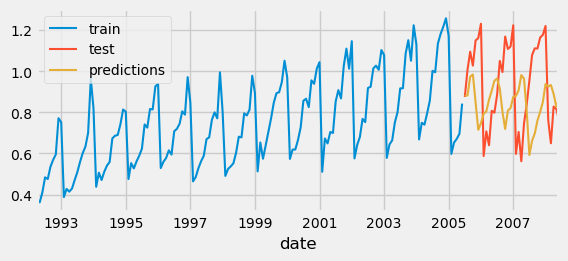

In [16]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

The error that the model makes in its predictions is quantified. In this case, the metric used is the mean squared error (mse)

In [17]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.07326833976120374


### Hyperparameter tuning

The trained ForecasterAutoreg uses a 6 lag time window and a Random Forest model with the default hyperparameters. However, there is no reason why these values are the most suitable. In order to identify the best combination of lags and hyperparameters, the Skforecast library provides the grid_search_forecaster function. It compares the results obtained with each model configuration.

In [18]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 36,
      initial_train_size = int(len(data_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,

    )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.02177319540541341


In [19]:
# Search results
# ==============================================================================
results_grid

lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
5                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
6                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
7                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   

                                          lags_label  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
5                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
6                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
7                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   

                                  params  mean_squared_error  max_depth  \
0  {'max_depth': 3, 'n_estimators': 250}            0.021773          3   
1  {'max_depth': 8, 'n_estimators': 250}            0.022068          8   
2  {'max_depth': 3, 'n_estimators': 100}            0.022569          3   
3  {'max_depth': 8, 'n_estimators': 100}            0.023562          8   
4  {'max_depth': 3, 'n_estimators': 100}            0.063144          3   
5  {'max_depth': 3, 'n_estimators': 250}            0.064241          3   
6  {'max_depth': 8, 'n_estimators': 250}            0.064546          8   
7  {'max_depth': 8, 'n_estimators': 100}            0.068730          8   

   n_estimators  
0           250  
1           250  
2           100  
3           100  
4           100  
5           250  
6           250  
7           100

The best results are obtained using a time window of 20 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 250}.

### Final model

Finally, a ForecasterAutoreg is trained with the optimal configuration found by validation. This step is not necessary if return_best = True is specified in the grid_search_forecaster function.

In [20]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = RandomForestRegressor(n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 20
             )
forecaster.fit(y=data_train['y'])

In [21]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

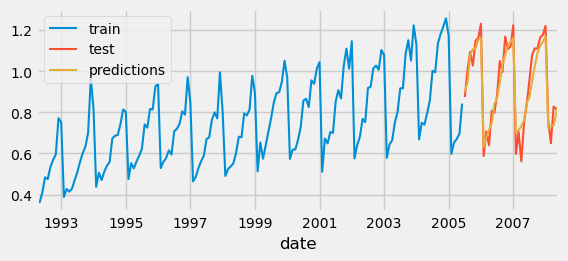

In [22]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [23]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.004356831371529945


The optimal combination of hyperparameters significantly reduces test error.

## Backtesting

Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s).

### Backtesting with refit and increasing training size (fixed origin)

The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

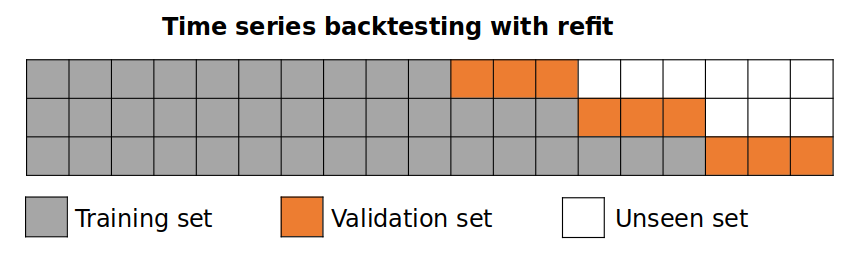

### Backtesting with refit and fixed training size (rolling origin)

A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

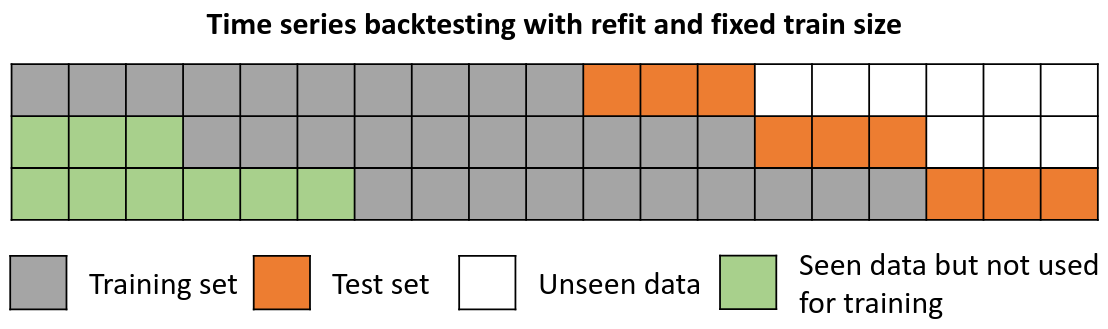

### Backtesting without refit

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest data available, so it may lose predictive capacity over time.

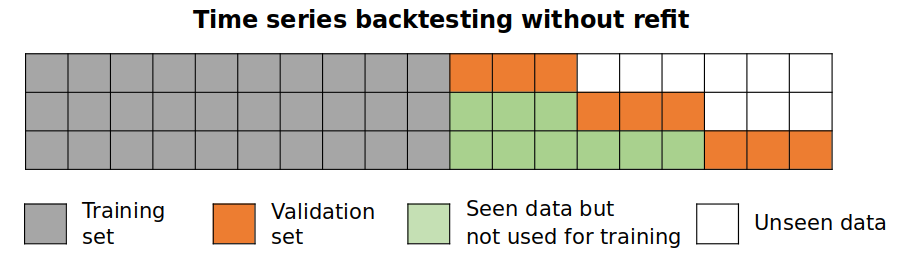

The skforecast library has the mentioned backtesting strategies implemented. Regardless of which one is used, it is important not to include test data in the search process to avoid overfitting problems.

For this example, a backtesting with refit strategy is followed. Internally, the process that the function applies is:

- In the first iteration, the model is trained with the observations selected for the initial training (in this case, 87). Then, the next 36 observations are used to validate the predictions of this first model.
- In the second iteration, the model is retrained by adding, to the initial training set, the previous 36 validation observations (87 + 36). In the same way, the next 36 observations are established as the new validation set.
- This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being predicted.


In [24]:
# Backtesting partitions using TimeSeriesFold
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12 * 3, 
         initial_train_size = len(data) - 12 * 9,  # Last 9 years are separated for the backtest
         window_size        = 20,
         fixed_train_size   = False,
         refit              = True,
     )

cv.split(X=data, as_pandas=True)

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



fold  train_start  train_end  last_window_start  last_window_end  \
0     0            0         87                 67               87   
1     1            0        123                103              123   
2     2            0        159                139              159   

   test_start  test_end  test_start_with_gap  test_end_with_gap  \
0          87       123                   87                123   
1         123       159                  123                159   
2         159       195                  159                195   

   fit_forecaster  
0            True  
1            True  
2            True

In [25]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
metric

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

mean_squared_error
0            0.010233

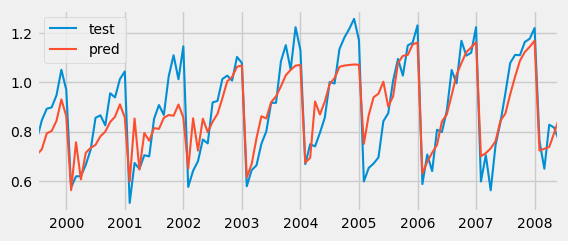

In [26]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Predictors importance

Since the ForecasterAutoreg object uses Scikit-learn models, the importance of predictors can be accessed once trained. When the regressor used is a LinearRegression(), Lasso() or Ridge(), the coefficients of the model reflect their importance. In GradientBoostingRegressor() or RandomForestRegressor() regressors, the importance of predictors is based on impurity. (The Higher the result the more important)

Note: the get_feature_importance() method only returns values if the regressor used within the forecaster has the attribute coef_ or feature_importances_.

In [27]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importances()
importance.head(10)

feature  importance
11  lag_12    0.815564
1    lag_2    0.086286
13  lag_14    0.019047
9   lag_10    0.013819
2    lag_3    0.012943
14  lag_15    0.009637
0    lag_1    0.009141
10  lag_11    0.008130
7    lag_8    0.007377
8    lag_9    0.005268

### Shap values

SHAP (SHapley Additive exPlanations) values are a popular method for explaining machine learning models, as they help to understand how variables and values influence predictions visually and quantitatively.

It is possible to generate SHAP-values explanations from skforecast models with just two essential elements:

The internal regressor of the forecaster.

The training matrices created from the time series and used to fit the forecaster.

By leveraging these two components, users can create insightful and interpretable explanations for their skforecast models. These explanations can be used to verify the reliability of the model, identify the most significant factors that contribute to model predictions, and gain a deeper understanding of the underlying relationship between the input variables and the target variable.

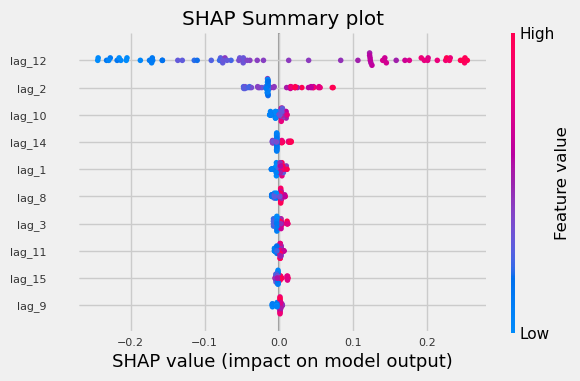

In [28]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=data_train['y'])

# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)
# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(6, 3.5)


## Recursive autoregressive forecasting with exogenous variables

In [32]:
# Data preparation
# ==============================================================================
data = pd.read_csv('h2o_exog.csv')
data = data.rename(columns={'fecha': 'date'})
data.date = data.date.str.replace('-', '/')
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

In the previous example, only lags of the predicted variable itself have been used as predictors. In certain scenarios, it is possible to have information about other variables, whose future value is known, so could serve as additional predictors in the model.

Continuing with the previous example, a new variable whose behavior is correlated with the modeled time series and we want to incorporate as a predictor is simulated. The same applies to multiple exogenous variables.

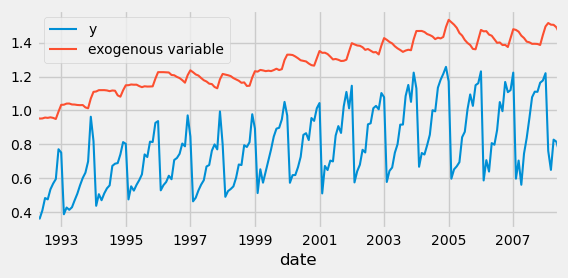

In [33]:
fig, ax = plt.subplots(figsize=(6, 2.7))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend(loc='upper left');

In [34]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


### ForecasterAutoreg

In [35]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )
forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])

### Predictions

If the ForecasterAutoreg is trained with an exogenous variable, the value of this variable must be passed to predict(). It is only applicable to scenarios in which future information on the exogenous variable is available.

In [36]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

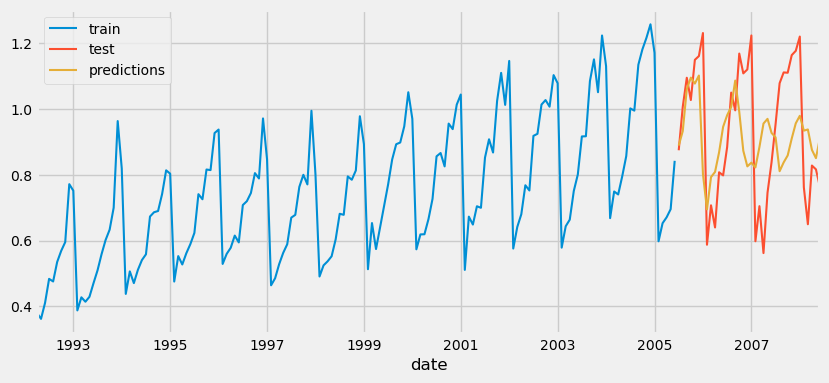

In [37]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [38]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.03989087922533575


### Hyperparameter tuning

In [43]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8 # This value will be replaced in the grid search
             )
# Training and validation folds
cv = TimeSeriesFold(
      steps              = 36,
      initial_train_size = int(len(data_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,

    )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train['exog_1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        cv=cv,
                        metric      = 'mean_squared_error',
                        return_best = True,
                        verbose     = False
               )

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.020919321798477056


In [44]:
# Grid Search results
# ==============================================================================
results_grid.head()

lags  \
0            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
1            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                          lags_label  \
0            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
1            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                   params  mean_squared_error  max_depth  \
0   {'max_depth': 10, 'n_estimators': 50}            0.020919         10   
1    {'max_depth': 5, 'n_estimators': 50}            0.021596          5   
2   {'max_depth': 5, 'n_estimators': 500}            0.021759          5   
3   {'max_depth': 3, 'n_estimators': 500}            0.021839          3   
4  {'max_depth': 10, 'n_estimators': 500}            0.021968         10   

   n_estimators  
0            50  
1            50  
2           500  
3           500  
4           500

The best results are obtained using a time window of 12 lags and a Random Forest set up of {'max_depth': 10, 'n_estimators': 50}.

### Final model

Setting return_best = True in grid_search_forecaster, after the search, the ForecasterAutoreg object has been modified and trained with the best configuration found.

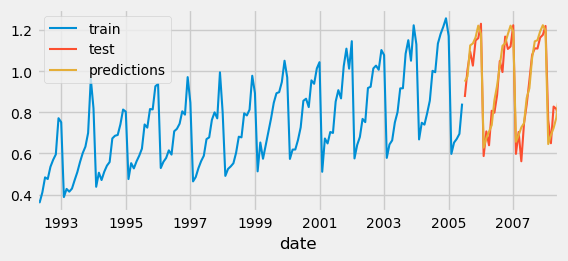

In [47]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [48]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.0044949967759907675


## Recursive autoregressive forecasting with custom predictors

#### Window and custom features
When forecasting time series data, it may be useful to consider additional characteristics beyond just the lagged values. For example, the moving average of the previous n values may help to capture the trend in the series. The window_features argument allows the inclusion of additional predictors created with the previous values of the series.

The RollingFeatures class availabe is skforecast allows the creation of some of the most commonly used predictors- :

'mean': the mean of the previous n val- ues.
'std': the standard deviation of the previous n va- lues.
'min': the minimum of the previous n v- alues.
'max': the maximum of the previous n - values.
'sum': the sum of the previous n-  values.
'median': the median of the previous - n values.
'ratio_min_max': the ratio between the minimum and maximum of the previous-  n values.
'coef_variation': the coefficient of variation of the previous n values.
The user can specify a different window size for each of them or the same for all of them.

In [49]:
# Data preparation
# ==============================================================================
data = pd.read_csv('h2o_exog.csv')
data = data.rename(columns={'fecha': 'date'})
data.date = data.date.str.replace('-', '/')
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


A new ForecasterRecursive is created and trained using a RandomForestRegressor regressor, this time including, in addition to the 10 lags, the moving average, maximum, minimum and standard deviation of the last 20 values in the series.

In [50]:
# Window features
# ==============================================================================
window_features = RollingFeatures(
    stats = ['mean', 'std', 'min', 'max'],
    window_sizes = 20
)

In [51]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor       = RandomForestRegressor(random_state=123),
                lags            = 10,
                window_features = window_features,
             )
forecaster.fit(y=data_train['y'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: ['roll_mean_20', 'roll_std_20', 'roll_min_20', 'roll_max_20'] 
Window size: 20 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-03 10:04:10 
Last fit date: 2025-04-03 10:04:10 
Skforecast version: 0.15.0 
Python version: 3.12.7 
Forecaster id: None

In [52]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

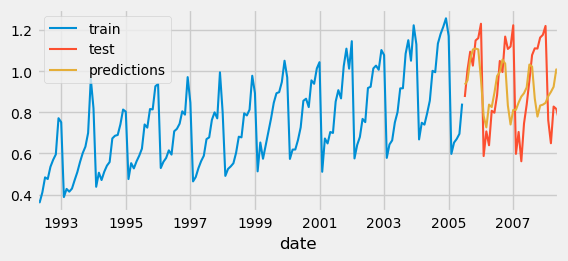

In [53]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [54]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.04180143590431811


### Direct multi-step forecasting
ForecasterRecursive models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. These kinds of models can be obtained with the ForecasterDirect class and can include one or multiple exogenous variables.

⚠ Warning

`ForecasterRecursiveDirect` may require long training times, as one model is fitted for each step.
Unlike when using ForecasterRecursive, the number of steps to be predicted must be indicated in the ForecasterDirect. This means that it is not possible to predict steps beyond the value defined at their creation when executing the predict() method.

For this example, a linear model with Ridge penalty is used as a regressor. These models require the predictors to be standardized, so it is combined with a StandardScaler.

In [55]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 steps         = 36,
                 lags          = 8,  # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

In [56]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = int(len(data_train) * 0.5),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster   = forecaster,
                    y            = data_train['y'],
                    cv           = cv,
                    param_grid   = param_grid,
                    lags_grid    = lags_grid,
                    metric       = 'mean_squared_error',
                    return_best  = True
                )

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.2782559402207126}
  Backtesting metric: 0.027413948265204567


In [57]:
# Search results
# ==============================================================================
results_grid.head()

lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   

                                lags_label                            params  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]     {'alpha': 0.2782559402207126}   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]      {'alpha': 3.593813663804626}   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   {'alpha': 0.021544346900318846}   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  {'alpha': 0.0016681005372000592}   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  {'alpha': 0.0001291549665014884}   

   mean_squared_error     alpha  
0            0.027414  0.278256  
1            0.027435  3.593814  
2            0.027484  0.021544  
3            0.027490  0.001668  
4            0.027491  0.000129

The best results are obtained using a time window of 12 lags and a Ridge setting {'alpha': 0.278256}.

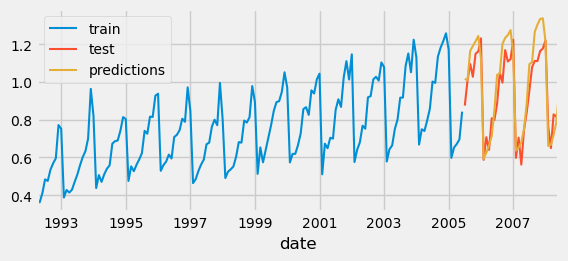

In [58]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [59]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'], 
                y_pred = predictions
            )
print(f"Test error (MSE) {error_mse}")

Test error (MSE) 0.011792965469623133


## Probabilistic forecasting

Probabilistic forecasting, as opposed to point-forecasting, is a family of techniques that allow the prediction of the expected distribution of the outcome rather than a single future value. This type of forecasting provides much richer information because it allows the creation of prediction intervals, the range of likely values where the true value may fall. More formally, a prediction interval defines the interval within which the true value of the response variable is expected to be found with a given probability.

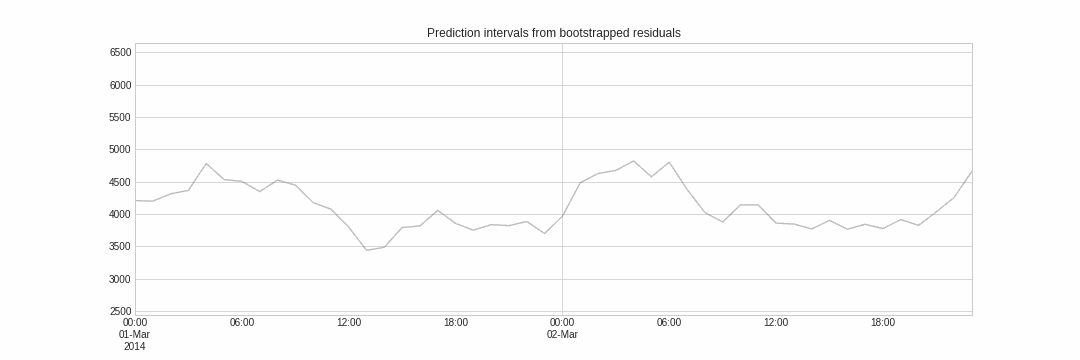

In [60]:
# Data preparation
# ==============================================================================
data = pd.read_csv('h2o_exog.csv')
data = data.rename(columns={'fecha': 'date'})
data.date = data.date.str.replace('-', '/')
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [61]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(alpha=0.1, random_state=765),
                 lags      = 15
             )
forecaster.fit(y=data_train['y'], store_in_sample_residuals=True)

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                steps    = steps,
                interval = [5, 95],
                method   = 'bootstrapping',
                n_boot   = 150
              )
predictions.head(5)

pred  lower_bound  upper_bound
2005-07-01  0.970598     0.788690     1.059012
2005-08-01  0.990932     0.815214     1.102761
2005-09-01  1.149609     1.064396     1.258934
2005-10-01  1.194584     1.098682     1.313509
2005-11-01  1.231744     1.122570     1.355601

Test error (MSE): 0.0104650861617912


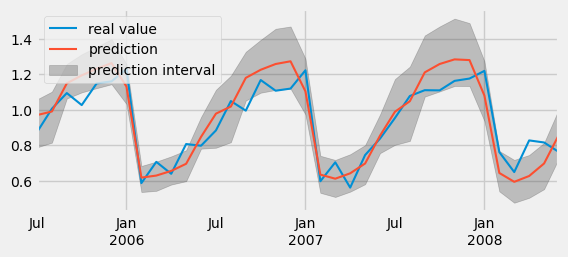

In [62]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (MSE): {error_mse}")

# Plot forecasts with prediction intervals
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "y",
    ax              = ax
)

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

mean_squared_error
0            0.012641

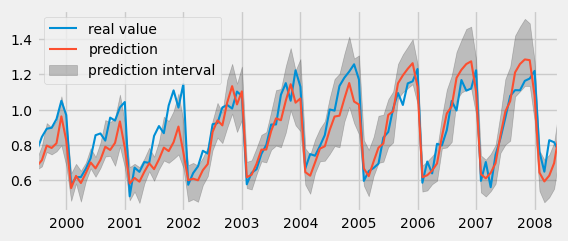

In [63]:
# Backtest with prediction intervals
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(alpha=0.1, random_state=765),
                 lags      = 15
             )
cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = len(data) - 12 * 9,
         fixed_train_size   = False,
         refit              = True,
)
metric, predictions = backtesting_forecaster(
                            forecaster      = forecaster,
                            y               = data['y'],
                            cv              = cv,
                            metric          = 'mean_squared_error',
                            interval        = [5, 95],
                            interval_method = "bootstrapping",
                            n_boot          = 150,
                            verbose         = True
                       )
display(metric)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data.loc[predictions.index, :],
    target_variable = "y",
    ax              = ax
)

In [64]:
# Predicted interval coverage
# ==============================================================================
coverage = calculate_coverage(
                y_true      = data.loc[predictions.index, 'y'],
                lower_bound = predictions['lower_bound'],
                upper_bound = predictions['upper_bound'],
            )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

Predicted interval coverage: 77.78 %


## Custom metric

In the backtesting (backtesting_forecaster) and hyperparameter optimization (grid_search_forecaster) processes, besides the frequently used metrics: mean_squared_error, mean_absolute_error, and mean_absolute_percentage_error, it is possible to use any custom function as long as:

It includes the arguments:

- y_true: true values of the series.
- y_pred: predicted values.

It returns a numeric value (float or int).

The metric is reduced as the model improves. Only applies in the grid_search_forecaster function if return_best=True (train the forecaster with the best model).

It allows evaluating the predictive capability of the model in a wide range of scenarios, for example:

- Consider only certain months, days, hours...
- Consider only dates that are holidays.
- Consider only the last step of the predicted horizon.

The following example shows how to forecast a 12-month horizon but considering only the last 3 months of each year to calculate the interest metric.
  

In [65]:
## Custom metric 
# ==============================================================================
def custom_metric(y_true, y_pred):
    """
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [66]:
# Backtesting 
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                 forecaster = forecaster,
                                 y          = data['y'],
                                 cv         = cv,
                                 metric     = custom_metric,
                                 verbose    = True
                              )
metric

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

custom_metric
0       0.128159

## Save and load models

Skforecast models can be loaded and stored using Pickle or Joblib libraries. A simple example using Joblib is shown below.

In [67]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterRecursive(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data['y'])
forecaster.predict(steps=3)

2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

In [68]:
# Save forecaster
# ==============================================================================
save_forecaster(forecaster, file_name='forecaster.joblib', verbose=False)

In [69]:
# Load forecaster
# ==============================================================================
forecaster_loaded = load_forecaster('forecaster.joblib')

ForecasterRecursive 
Regressor: RandomForestRegressor 
Lags: [1 2 3] 
Window features: None 
Window size: 3 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-03 10:12:14 
Last fit date: 2025-04-03 10:12:14 
Skforecast version: 0.15.0 
Python vers

In [70]:
# Predict
forecaster_loaded.predict(steps=3)

2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

## Use forecaster in production

In projects related to forecasting, it is common to generate a model after the experimentation and development phase. For this model to have a positive impact on the business, it must be able to be put into production and generate forecasts from time to time with which to decide. This need has widely guided the development of the Skforecast library.

Suppose predictions have to be generated on a weekly basis, for example, every Monday. By default, when using the predict method on a trained forecaster object, predictions start right after the last training observation. Therefore, the model could be retrained weekly, just before the first prediction is needed, and call its predict method.

This strategy, although simple, may not be possible to use for several reasons:
- Model training is very expensive and cannot be run as often.
- The history with which the model was trained is no longer available.
- The prediction frequency is so high that there is no time to train the model between predictions.

In these scenarios, the model must be able to predict at any time, even if it has not been recently trained.

Every model generated using Skforecast has the last_window argument in its predict method. Using this argument, it is possible to provide only the past values needs to create the autoregressive predictors (lags) and thus, generate the predictions without the need to retrain the model.


In [71]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['y'])

Here, since the model uses the last 6 lags as predictors, last_window must contain at least the 6 values previous to the moment where the prediction starts.

In [72]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['y'])

In [ ]:
#!pip install notebook-as-pdf --user
#!pip install urllib3 --user
#!pyppeteer-install

If the forecaster uses exogenous variables, besides last_window, the argument exog must contain the future values of the exogenous variables.